In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools
import warnings
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)

2.8.0


In [2]:
image_size = (180, 180)
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "images/train",
    validation_split=0.4,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "images/train",
    validation_split=0.4,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3000 files belonging to 2 classes.
Using 1800 files for training.
Found 3000 files belonging to 2 classes.
Using 1200 files for validation.


visualising the data

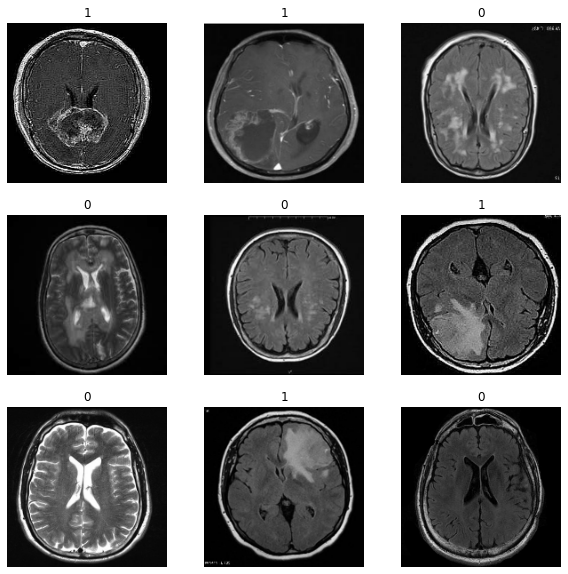

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


Using image data augmentation


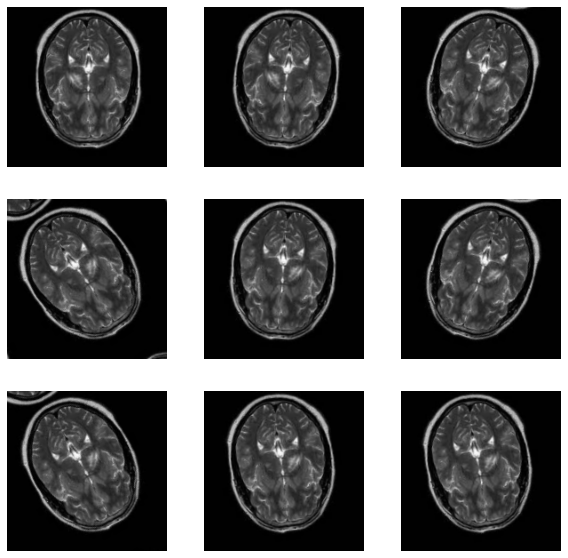

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [6]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.8)(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.8)(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.LeakyReLU(alpha=0.8)(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return tf.keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [11]:
epochs = 20

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/20
29/29 [==============================] - 530s 18s/step - loss: 0.5938 - accuracy: 0.7233 - val_loss: 0.6920 - val_accuracy: 0.4850
Epoch 2/20
29/29 [==============================] - 527s 18s/step - loss: 0.5055 - accuracy: 0.7694 - val_loss: 0.6953 - val_accuracy: 0.5175
Epoch 3/20
29/29 [==============================] - 492s 17s/step - loss: 0.4353 - accuracy: 0.8067 - val_loss: 0.6856 - val_accuracy: 0.5675
Epoch 4/20
29/29 [==============================] - 458s 16s/step - loss: 0.4217 - accuracy: 0.8200 - val_loss: 0.6737 - val_accuracy: 0.6050
Epoch 5/20
29/29 [==============================] - 807s 28s/step - loss: 0.3580 - accuracy: 0.8494 - val_loss: 0.6872 - val_accuracy: 0.5292
Epoch 6/20
29/29 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.8511 

KeyboardInterrupt: 